## import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import random

import torch
from torchtext.legacy import data
import torchtext
import torch.nn as nn
import torch.nn.functional as F


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



## Load Dataset

In [2]:
train = pd.read_csv("train.csv", encoding='CP949')
test = pd.read_csv("test.csv", encoding='CP949')
sub = pd.read_csv("sample.csv", encoding='CP949')

# EDA

## 데이터셋 확인 작업

In [3]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [4]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [5]:
sub.head()

,index,label
0,0,contradiction
1,1,contradiction
2,2,entailment
3,3,neutral
4,4,neutral


# 갯수 확인

In [6]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)


train 19996 개
test 5000 개

# 중복값 확인

In [7]:
train.drop_duplicates(subset = ['premise','hypothesis'],inplace = True)
test.drop_duplicates(subset = ['premise','hypothesis'],inplace = True)

In [8]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)


중복 값 없음


# 데이터 결측치 계산

In [9]:
train.isnull().sum()

index         0
premise       0
hypothesis    0
label         0
dtype: int64

## 라벨값이 balanced 한지 확인 하는 시각화 작업

막대 그래프

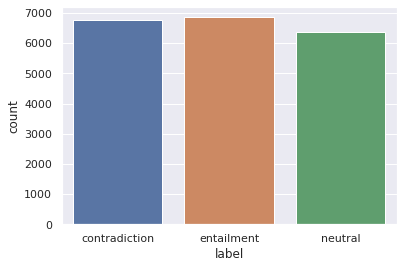

In [10]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

원그래프

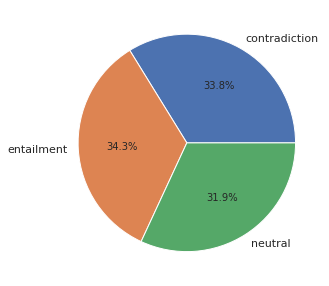

In [11]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

# 결과 도출

데이터들이 골고루 잘 분포되어 있음

### LabelEncoder를 활용해 categorical features를 encode함
contradiction => 0  
entailment => 1  
neutral => 2

In [12]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

결측치 없음

### train, valid split

In [13]:
new_train,new_valid = train_test_split(train)
print(f"train shape => {new_train.shape} \ntest shape => {new_valid.shape}")
new_train.head()

train shape => (14997, 4) 
test shape => (4999, 4)


,index,premise,hypothesis,label
17854,17855,지난 2014년 아마존이 9억 7000만 달러에 인수해 화제가 됐다.,지난 2014년 아마존이 인수한 것은 누구도 알지 못했다.,0
16568,16569,안전한지역 저렴한가격 착한호스트 다좋습니다,치안이 안전한 지역입니다.,2
10154,10155,이날 회의에서 홍 부총리는 일본 수출규제조치 1년을 맞아 일본에 진전된 입장을 보여...,일본 수출규제조치가 내려진지 1년이 경과했다.,1
14622,14623,이라크 남부 시아파 성지인 카르발라 시 교외에서 2건의 자살 차량폭탄 공격으로 적어...,카르발라 시 교외에서 1건의 자살 차량폭탄 공격이 있었다.,0
5407,5408,1991년 통계작성 이래 최저 수치다.,1991년 통계작성 이래 최고 수치다.,0


In [14]:
new_train.to_csv("new_train.txt",index = False) #train data
new_valid.to_csv("new_valid.txt",index = False) #valid data
test.to_csv("new_test.txt",index = False) #test data

# tokenizer

In [15]:
from konlpy.tag import Mecab
tokenizer = Mecab()

# field 로 데이터 처리

In [98]:
max_len = 98

index = data.Field(sequential = False,
                 use_vocab = False) # 사용하지 않음

premise = data.Field(use_vocab=True,
                     sequential = True,
                     tokenize=tokenizer.morphs,
                     lower=True,
                     batch_first=True,
                     fix_length= max_len)

hypothesis = data.Field(use_vocab=True,
                        sequential = True,
                        tokenize=tokenizer.morphs,
                        lower=True,
                        batch_first=True,
                        fix_length= max_len)

LABEL = data.Field(sequential = False,batch_first = True,is_target = True,
                   use_vocab = False,dtype = torch.int64)

### 훈련에 사용할 데이터로 변환

In [141]:
field = [("index",index),('premise',premise),('hypothesis',hypothesis),('label',LABEL)]

train_data ,valid_data ,test_data = data.TabularDataset.splits(
    path='.', train="new_train.txt",validation = "new_valid.txt" ,test="new_test.txt", format='csv',
    fields=field, skip_header=True,
)

In [178]:
print(f'training examples 수 : {len(train_data)}')
print(f'validations examples 수 : {len(valid_data)}')
print(f'testing examples 수 : {len(test_data)}\n')

print(vars(train_data[-1]))
print(vars(train_data[-2]))

training examples 수 : 14997
validations examples 수 : 4999
testing examples 수 : 5000

{'index': '15115', 'premise': ['일본', '기리시마', '산맥', '의', '신모', '에다', '케', '화산', '이', '지난', '27', '일', '오후', '3', '시', '41', '분', '께', '52', '년', '만', '에', '폭발', '했', '다', '.'], 'hypothesis': ['신모', '에다', '케', '화산', '은', '아프리카', '에', '만', '존재', '한다', '.'], 'label': '0'}
{'index': '12023', 'premise': ['락앤락', '은', '밀폐', '용기', '를', '주력', '으로', '하', '는', '주방', '용품', '제조사', '다', '.'], 'hypothesis': ['락앤락', '은', '주방', '용품', '업계', '1', '위', '이', '다', '.'], 'label': '2'}


### fasttext.simple.300d 의 학습된 임베딩 벡터를 사용합니다.

In [179]:
premise.build_vocab((train_data.premise,train_data.hypothesis) ,
                 vectors = "fasttext.simple.300d",
                 unk_init = torch.Tensor.normal_)

hypothesis.build_vocab(train_data, 
                  vectors = "fasttext.simple.300d",
                  unk_init = torch.Tensor.normal_)

hypothesis.vocab = premise.vocab

LABEL.build_vocab(train_data)

In [180]:
print(f"Unique tokens in premise vocabulary: {len(premise.vocab)}")
#print(f"Unique tokens in hypothesis vocabulary: {len(hypothesis.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(premise.vocab.stoi)

Unique tokens in premise vocabulary: 18661
Unique tokens in LABEL vocabulary: 4
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f271d0a8b50>>, {'<unk>': 0, '<pad>': 1, '.': 2, '는': 3, '이': 4, '다': 5, '을': 6, '에': 7, '은': 8, '의': 9, '하': 10, '를': 11, '가': 12, '있': 13, '한': 14, '고': 15, ',': 16, '에서': 17, '도': 18, '으로': 19, '들': 20, '습니다': 21, '했': 22, '로': 23, '었': 24, '과': 25, '영화': 26, '것': 27, '적': 28, '되': 29, '지': 30, '와': 31, '수': 32, '한다': 33, '기': 34, '할': 35, '게': 36, '만': 37, '인': 38, '일': 39, '없': 40, '않': 41, '등': 42, '년': 43, '았': 44, '해': 45, '좋': 46, '어': 47, '던': 48, '였': 49, '중': 50, '된다': 51, '된': 52, '받': 53, '에게': 54, '어요': 55, '숙소': 56, '명': 57, '입니다': 58, '합니다': 59, '월': 60, '까지': 61, '1': 62, '그': 63, '지원': 64, '면': 65, '위해': 66, '2': 67, '보': 68, '대한': 69, '지만': 70, '3': 71, '사람': 72, '다고': 73, '나': 74, '위치': 75, '원': 76, '아': 77, '여': 78, '같': 79, '며': 80, '호스트': 81, '집': 82, '보다': 83, '씨': 84, '사업': 85, '부터': 86,

In [181]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA TITAN RTX


In [182]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
#     sort_key=lambda x: len(x.comment_text),
#     sort_within_batch = False,
    sort = False,
    device = device
)

In [198]:
batch = next(iter(train_iterator)) # 첫번째 미니배치
print(batch)
print(batch.premise)
print(batch.hypothesis)


[torchtext.legacy.data.batch.Batch of size 64]
	[.index]:[torch.cuda.LongTensor of size 64 (GPU 0)]
	[.premise]:[torch.cuda.LongTensor of size 64x98 (GPU 0)]
	[.hypothesis]:[torch.cuda.LongTensor of size 64x98 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)]
tensor([[   98,    31,  7688,  ...,     1,     1,     1],
        [  150,  2328,    43,  ...,     1,     1,     1],
        [ 2248,    12, 10432,  ...,     1,     1,     1],
        ...,
        [  590,    17,     3,  ...,     1,     1,     1],
        [  161,  1074,  6970,  ...,     1,     1,     1],
        [ 1048,    20,     4,  ...,     1,     1,     1]], device='cuda:0')
tensor([[7688,  692,   20,  ...,    1,    1,    1],
        [1312,   43, 1359,  ...,    1,    1,    1],
        [2248,   12, 8359,  ...,    1,    1,    1],
        ...,
        [7339,    9, 5575,  ...,    1,    1,    1],
        [1074, 6970,  248,  ...,    1,    1,    1],
        [1048,   20,    8,  ...,    1,    1,    1]], device='cuda:0')


In [183]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
               n_filters, filter_sizes,
               output_dim,
               dropout, 
               pad_idx 
               ): 
    
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        embedded = self.embedding(text).unsqueeze(1)

        conved = [F.relu(conv(embedded).squeeze(3)) for conv in self.convs]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(cat)

In [184]:
INPUT_DIM = len(premise.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = premise.vocab.stoi[premise.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [185]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,869,804 trainable parameters


In [187]:
pretrained_embeddings = premise.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([18661, 300])


tensor([[-0.0961, -0.9239,  1.3571,  ...,  1.5096, -0.9949,  0.0029],
        [ 0.2258, -0.1008, -0.6930,  ..., -0.1473,  0.0953,  1.5839],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        ...,
        [ 2.7568,  0.8018,  0.5548,  ..., -0.2613, -1.1476, -0.6342],
        [-1.0507,  1.3836, -0.3647,  ..., -0.2531,  2.3174,  1.4276],
        [ 1.5755, -1.2226,  1.0024,  ...,  1.6635, -0.2262,  0.2917]])

In [188]:
UNK_IDX = premise.vocab.stoi[premise.unk_token] #0

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        ...,
        [ 2.7568,  0.8018,  0.5548,  ..., -0.2613, -1.1476, -0.6342],
        [-1.0507,  1.3836, -0.3647,  ..., -0.2531,  2.3174,  1.4276],
        [ 1.5755, -1.2226,  1.0024,  ...,  1.6635, -0.2262,  0.2917]])


# Train

### optimizer

In [189]:
import torch.optim as optim

optimizer =optim.Adam(model.parameters())

### Loss

In [190]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### accuracy fun

In [191]:
def categorical_accuracy(preds, y):

    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [203]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        # 모든 batch마다 gradient를 0으로 초기화합니다.
        optimizer.zero_grad()

        # batch of sentences인 batch.text를 model에 입력합니다.
        predictions = model(batch.premise)

        # prediction결과와 batch.label을 비교하여 loss값 계산합니다.
        loss = criterion(predictions, batch.label)

        # 정확도를 계산합니다.
        acc = categorical_accuracy(predictions, batch.label)

        # backward()를 사용하여 역전파 수행합니다.
        loss.backward()

        # 최적화 알고리즘을 사용하여 parameter를 update합니다.
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [204]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    # "evaluation mode" : dropout이나 batch nomalizaation을 끔
    model.eval()

    # pytorch에서 gradient가 계산되지 않도록 해서 memory를 적게 쓰고 computation 속도를 높임
    with torch.no_grad():
        
        for batch in iterator :

            predictions = model(batch.premise).squeeze(1)

            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [205]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [206]:
N_EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ai-competition-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.227 | Train Acc: 30.87%
	 Val. Loss: 1.135 |  Val. Acc: 27.75%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.124 | Train Acc: 33.80%
	 Val. Loss: 1.132 |  Val. Acc: 30.88%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.114 | Train Acc: 34.67%
	 Val. Loss: 1.155 |  Val. Acc: 33.85%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.117 | Train Acc: 34.04%
	 Val. Loss: 1.136 |  Val. Acc: 19.43%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.115 | Train Acc: 35.59%
	 Val. Loss: 1.157 |  Val. Acc: 26.99%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.111 | Train Acc: 36.68%
	 Val. Loss: 1.172 |  Val. Acc: 30.63%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.108 | Train Acc: 36.66%
	 Val. Loss: 1.183 |  Val. Acc: 15.31%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.096 | Train Acc: 37.96%
	 Val. Loss: 1.216 |  Val. Acc: 13.25%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.087 | Train Acc: 39.86%
	 Val. Loss: 1.250 |  Val. Acc: 17.09%
Epoch: 10 | Epoch Time: 0m 1

KeyboardInterrupt: 